In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
import pickle

In [92]:
"""
Loads annotator response file consisting of multiple annotator responses per attribute per image. 
Outputs a dictionary:
    'scores': data matrix of size N x n_attr, where N is number of images, n_attr is number of attributes.
    'attributes': list of n_attr names
    
This function also prunes uncanny images based on a given threshold. 
"""
def responses_to_single_score(file, uncanny_threshold=0.8):
    with open(file, 'rb') as pkl_file:
        dic = pickle.load(pkl_file)

        X = []
        for s,l in zip(dic['responses'],  dic['attribute_levels']):  
            # Take average of annotations, except for smallest/largest
            s.sort(1)
            s = np.mean(s[:, 1:-1], 1)
            
            # Divide by the number of labels so that scores are in [0,1]
            s = s/( len(l) - 1 )
            
            X.append(s) 
            
        X = np.stack(X, 1)

        # Remove uncanny images based on threshold, if the 'uncanny' attribute exists.
        if 'uncanny' in dic['attributes'] and uncanny_threshold is not None:
            uncanny_idx = dic['attributes'].index('uncanny')
            good_images = np.where(X[:, uncanny_idx] < uncanny_threshold)[0]
            X = X[good_images, ...]
                
    return {'scores': X, 'attributes': dic['attributes']}

In [93]:
dataset_names = ['celeba-hq', 'ffhq', 'stylegan2', 'transects']
all_datasets = [responses_to_single_score('./datasets/%s/annotations.pkl' % d) for d in dataset_names]

In [94]:
SMALL_SIZE = 12
LARGE_SIZE = 18
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title
plt.rc('axes', labelsize=LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

## Violin plots of attribute distributions split by gender

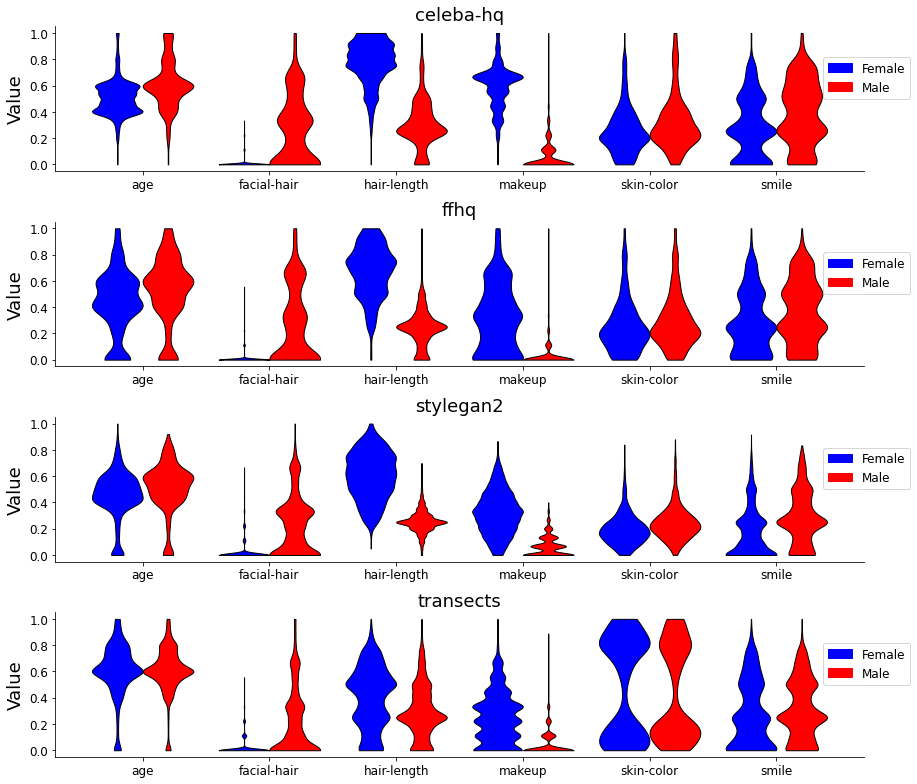

In [95]:
N = len(datasets)
fig, axes = plt.subplots(nrows=N, ncols=1, figsize=(13, 11))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.25)

vis_attributes = ['age', 'facial-hair', 'hair-length', 'makeup', 'skin-color', 'smile']
n_attr = len(vis_attributes)
gender_bins = [ [0, 0.4], [0.6, 1] ]

for i, dataset in enumerate(all_datasets):

    X, labels = dataset['scores'], dataset['attributes']
    X_gender = X[:, labels.index('gender')]
    
    ax = plt.subplot(N, 1, i+1) 
    patches = []
    colors = ['b', 'r']
    for j, b in enumerate(gender_bins):  
        idx = np.where( np.logical_and(X_gender >= b[0], X_gender <= b[1]) )[0]
        X_j = np.stack([X[idx, labels.index(a)] for a in vis_attributes], 1)  
    
        offset = -0.1 if j == 0 else 0.1 
        
        parts = ax.violinplot(
            X_j, 
            [0.5*k+offset for k in range(n_attr)], 
            widths=0.20, 
            showextrema=False)
        
        for pc in parts['bodies']:
            pc.set_facecolor( colors[j] )
            pc.set_edgecolor('black')
            pc.set_alpha(1)
            
        patches.append( mpatches.Patch(edgecolor=colors[j], facecolor=colors[j]) )
            
    ax.set_xticks( [0.5*k for k in range(n_attr) ] )
    ax.set_xticklabels(vis_attributes)
    ax.set_ylabel('Value')
    plt.title(dataset_names[i])
    
    ax.legend(patches, ['Female', 'Male'], loc=(0.95,0.50))
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()
#plt.savefig('dataset-comparison.pdf') 